In [1]:
!pip install efficientnet_pytorch
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import utils
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from PIL import Image
from sklearn.metrics import roc_curve, auc, confusion_matrix
import torch.nn.functional as F
from torchvision.models import vgg19
from torch.cuda.amp import GradScaler, autocast
import albumentations as A
from albumentations.pytorch import ToTensorV2
import functools
import random
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import tqdm
from torchvision.transforms.functional import to_pil_image

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=3517dad6b6b9777c7089c5098b2d2cd46e73b48623b2d7fb9a6aa7ff93acccbf
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR_IMAGE_PATH = "/kaggle/input/super-res/Dataset 3A/Dataset/LR"
HR_IMAGE_PATH = "/kaggle/input/super-res/Dataset 3A/Dataset/HR"
LEARNING_RATE =  .0005  #.001 5
NUM_EPOCHS = 9
BATCH_SIZE = 32
NUM_WORKERS = 1
HIGH_RES = 150
LOW_RES = HIGH_RES // 2
IMG_CHANNELS = 1

random_seed = 42
random.seed(random_seed)

In [3]:
def transpose_channels(image, **kwargs):
    return np.transpose(image, (1, 2, 0))


highres_transform = A.Compose(
    [
        
        # A.Normalize(mean=[ 0.5], std=[.5]),
        # A.CenterCrop(120,120),
        ToTensorV2(),
    ]
)

lowres_transform = A.Compose(
    [
        # A.Normalize(mean=[ 0], std=[ 1]),
        # A.CenterCrop(120,120),
        ToTensorV2(),
    ]
)


both_transforms = A.Compose(
    [
        A.Lambda(image=transpose_channels),
#         A.HorizontalFlip(p=0.5),
#         A.RandomRotate90(p=0.5),
    ]
)

In [4]:
class SuperResDataset(torch.utils.data.Dataset):
    def __init__(self, root_lr, root_hr, transform=None, hr_transform=None, lr_transform=None, scale_factor=4):
        self.root_lr = root_lr
        self.root_hr = root_hr
        self.transform = transform
        self.hr_transform = hr_transform
        self.lr_transform = lr_transform
        self.scale_factor = scale_factor
        self.classes = sorted(os.listdir(self.root_hr))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        lr_files = os.listdir(self.root_lr)
        hr_files = os.listdir(self.root_hr)

        for file_name in lr_files:
            lr_file_path = os.path.join(self.root_lr, file_name)
            hr_file_path = os.path.join(self.root_hr, file_name)

            # Extract class name from the file name,
            cls = file_name.split('_')[0]
            class_idx = self.class_to_idx.get(cls, -1)

            if class_idx != -1 and os.path.exists(hr_file_path):
                samples.append((lr_file_path, hr_file_path, class_idx))

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        lr_file_path, hr_file_path, class_idx = self.samples[idx]
        lr_image = np.load(lr_file_path)
        hr_image = np.load(hr_file_path)

        # Apply transformations on both LR and HR images
        if self.transform:
            lr_image, hr_image = self.transform(image=lr_image)["image"], self.transform(image=hr_image)["image"]
        
        # Apply separate transformations on HR images
        if self.hr_transform:
            hr_image = self.hr_transform(image=hr_image)["image"]

        # Apply separate transformations on LR images
        if self.lr_transform:
            lr_image = self.lr_transform(image=lr_image)["image"]

        return lr_image, hr_image

In [5]:
dataset = SuperResDataset(
    root_lr=LR_IMAGE_PATH,
    root_hr=HR_IMAGE_PATH,
    transform=both_transforms,  # Apply both_transforms on both LR and HR images
    hr_transform=highres_transform,  # Apply highres_transform on HR images
    lr_transform=lowres_transform,  # Apply lowres_transform on LR images
)


In [6]:
# Split the dataset into training and validation sets
train_indices, val_indices = train_test_split(
    list(range(len(dataset))),
    test_size=0.1,
    random_state=42
)

In [7]:
# Create training and validation datasets
val_dataset = torch.utils.data.Subset(dataset, val_indices)
dataset = torch.utils.data.Subset(dataset, train_indices)

print(len(dataset),len(val_dataset))

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

9000 1000


In [8]:
batch_demo = next(iter(val_loader))
batch_demo[0].shape

torch.Size([32, 1, 75, 75])

In [9]:
batch_demo[1].shape

torch.Size([32, 1, 150, 150])

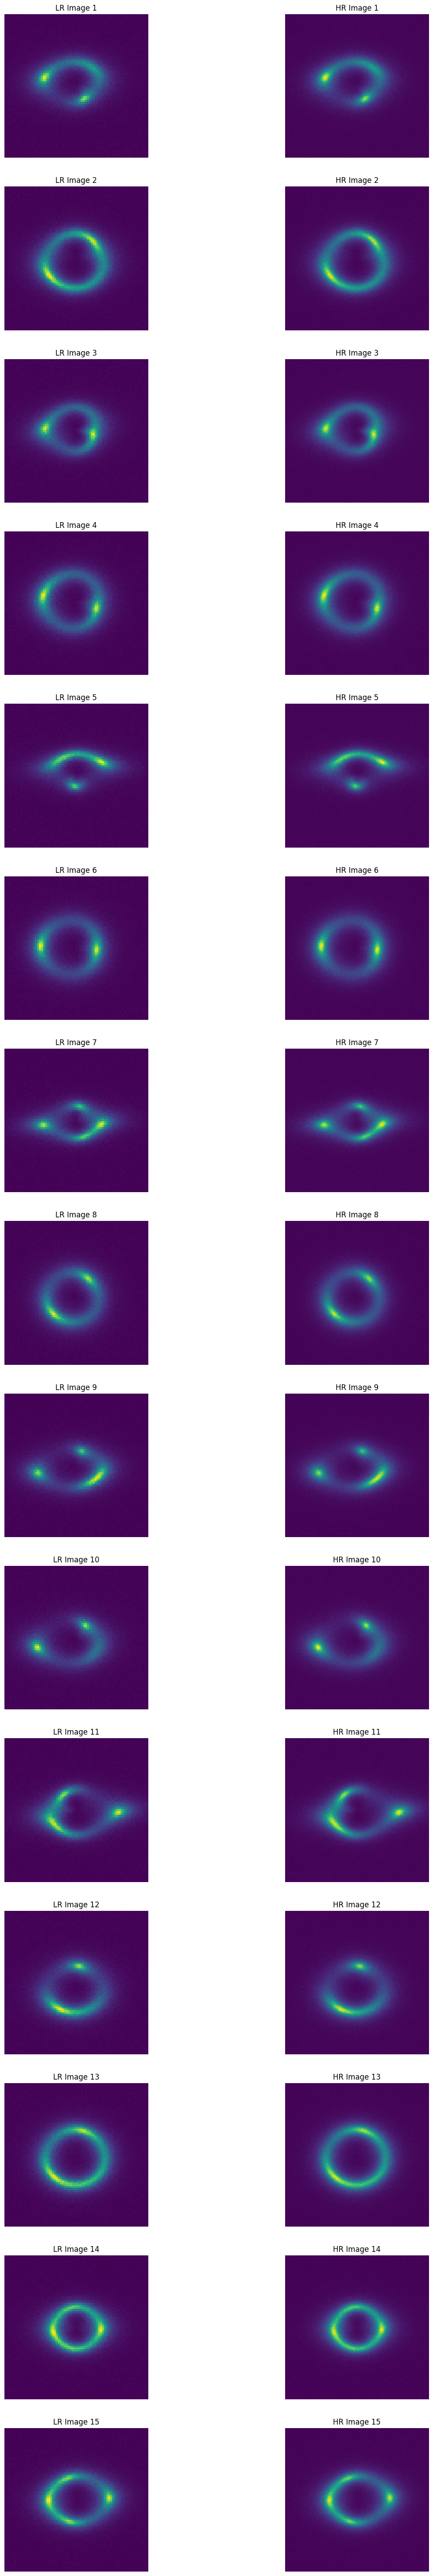

In [10]:
# Extract LR and HR images from the batch
lr_images, hr_images = batch_demo

# Define the number of images to display
num_images = min(len(lr_images), 15)  # Display up to 5 images

# Display LR vs HR pairs
plt.figure(figsize=(15, 5 * num_images))
for i in range(num_images):
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(np.transpose(lr_images[i].numpy(), (1, 2, 0)))
    plt.title(f'LR Image {i + 1}')
    plt.axis('off')

    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(np.transpose(hr_images[i].numpy(), (1, 2, 0)))
    plt.title(f'HR Image {i + 1}')
    plt.axis('off')

plt.show()

In [11]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        discriminator=False,
        use_act=True,
        use_bn=True,
        **kwargs,
    ):
        super().__init__()
        self.use_act = use_act
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = (
            nn.LeakyReLU(0.2, inplace=True)
            if discriminator
            else nn.PReLU(num_parameters=out_channels)
        )

    def forward(self, x):
        x = x.to(self.cnn.weight.dtype)
        return self.act(self.bn(self.cnn(x))) if self.use_act else self.bn(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, 3, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)  # in_c * 4, H, W --> in_c, H*2, W*2
        self.act = nn.PReLU(num_parameters=in_c)

    def forward(self, x):
        return self.act(self.ps(self.conv(x)))


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_act=False,
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out + x

In [12]:
class Generator(nn.Module):
    def __init__(self, in_channels=1, num_channels=64, num_blocks=16):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=9, stride=1, padding=4, use_bn=False)
        self.residuals = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.convblock = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_act=False)
        self.upsamples = nn.Sequential(UpsampleBlock(num_channels, 2))
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        x = self.residuals(initial)
        x = self.convblock(x) + initial
        x = self.upsamples(x)
        return self.final(x) # torch.tanh(self.final(x))

In [13]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    discriminator=True,
                    use_act=True,
                    use_bn=False if idx == 0 else True,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512*6*6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

In [14]:
low_resolution = 75  # 75x75 -> 150x150
with torch.cuda.amp.autocast():
    x = torch.randn((16, 1, low_resolution, low_resolution))
    gen = Generator()
    gen_out = gen(x)
    disc = Discriminator()
    disc_out = disc(gen_out)

    print(gen_out.shape)
    print(disc_out.shape)

torch.Size([16, 1, 150, 150])
torch.Size([16, 1])


In [15]:
class EfficientNetLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = model= EfficientNet.from_pretrained('efficientnet-b0').eval().to(DEVICE)
        # set channel to 1
        self.features = model._conv_stem = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)  # Set bias to False
        #load model weights from previous task
        self.features.load_state_dict(torch.load('/kaggle/input/efficient_net_weights/pytorch/weights/1/model_ckassification_weights.pth'),strict=False)
        self.loss = nn.MSELoss()
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        input = input.to(DEVICE)
        self.features  = self.features.to(input.device)
        efficientnet_input_features = self.features(input)
        efficientnet_target_features = self.features(target)
        return self.loss(efficientnet_input_features, efficientnet_target_features)


In [16]:
def calculate_metrics(img1, img2):
    ssim_value = ssim(img1, img2, data_range=1.0, full=False)
    psnr_value = psnr(img1, img2, data_range=1.0)
    mse_value = np.mean((img1 - img2) ** 2)
    return ssim_value, psnr_value, mse_value

def evaluate(val_loader, gen, output_folder, img):
    os.makedirs(output_folder, exist_ok=True)

    gen.eval()
    results = []
    total_ssim, total_psnr, total_mse = 0.0, 0.0, 0.0

    for batch_idx, (lr_images, hr_images) in enumerate(val_loader):
        for i in range(len(lr_images)):
            lr_image, hr_image = lr_images[i].unsqueeze(0).to(DEVICE), hr_images[i].unsqueeze(0).to(DEVICE)
            
            with torch.no_grad():
                upscaled_img = gen(lr_image)

            # Convert tensors to NumPy arrays
            lr_image_np = lr_image.squeeze().cpu().numpy()
            hr_image_np = hr_image.squeeze().cpu().numpy()
            upscaled_img_np = upscaled_img.squeeze().cpu().numpy()

            # Calculate SSIM, PSNR, and MSE
            ssim_value, psnr_value, mse_value = calculate_metrics(hr_image_np, upscaled_img_np)
            results.append((ssim_value, psnr_value, mse_value))
            # Accumulate SSIM, PSNR, and MSE for mean calculation
            total_ssim += ssim_value
            total_psnr += psnr_value
            total_mse += mse_value

    gen.train()

    # Calculate mean SSIM, PSNR, and MSE
    mean_ssim = total_ssim / len(results)
    mean_psnr = total_psnr / len(results)
    mean_mse = total_mse / len(results)

    # Write results to a text file
    print(f"Mean SSIM = {mean_ssim:.4f}, Mean PSNR = {mean_psnr:.4f}, Mean MSE = {mean_mse:.4f}\n") 


**only traing the genarator with l2 loss, so basically traing a deep residual SR model with mse**

In [17]:
train_losses = []
val_losses = []
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, EfficientNet_loss):
    train_loss = 0
    l2_losses = []
    adversarial_losses = []
    efficientnet_losses = []
    correct = 0
    total = 0

    for idx, (low_res, high_res) in enumerate(loader):
                
        high_res = high_res.to(DEVICE).float()
        low_res = low_res.to(DEVICE).float()   
        fake = gen(low_res)
        l2_loss = mse(fake, high_res)
        gen_loss =  l2_loss 
        train_loss += gen_loss.item()
        l2_losses.append(l2_loss.item())    
        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

    train_loss /= len(loader)
    train_losses.append(train_loss)
    
    l2_loss_mean = sum(l2_losses) / len(l2_losses)
    
    print(f"Training, Train Loss: {train_loss:.8f}, L2 Loss: {l2_loss_mean:.8f}")
    
    # Validation
    gen.eval()  # Set the generator to evaluation mode for validation
    with torch.no_grad():
        val_loss = 0.0
        l2_losses = []
        adversarial_losses = []
        efficientnet_losses = []
        for val_idx, (val_low_res, val_high_res) in enumerate(val_loader):
            val_low_res = val_low_res.to(DEVICE).float()
            val_high_res = val_high_res.to(DEVICE).float()
            val_fake = gen(val_low_res)
            l2_loss = mse(val_fake, val_high_res)
    
            gen_loss =  l2_loss 

            val_loss += gen_loss.item()
            
            l2_losses.append(l2_loss.item())


        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        l2_loss_mean = sum(l2_losses) / len(l2_losses)

        print(f"Validation, Val Loss: {val_loss:.8f}, L2 Loss: {l2_loss_mean:.8f}")#, Adversarial Loss: {adversarial_loss_mean:.8f}, EfficientNet Loss: {efficientnet_loss_mean:.8f}")


In [28]:
gen = Generator(in_channels=1).to(DEVICE)
#gen.load_state_dict(torch.load('gen_pretrain_l2_001_e3.pth'))

disc = Discriminator(in_channels=1).to(DEVICE)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
EfficientNet_loss =EfficientNetLoss().to(DEVICE)



Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 231MB/s]


Loaded pretrained weights for efficientnet-b0


In [39]:
for epoch in range(NUM_EPOCHS):
    print(epoch)
    train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, EfficientNet_loss)
    torch.save(gen.state_dict(), str(epoch)+'gen.pth')
    evaluate(val_loader, gen, output_folder = 'result/epoch'+str(epoch),img = True)
    



0
Training, Train Loss: 0.00010975, L2 Loss: 0.00010975
Validation, Val Loss: 0.00012003, L2 Loss: 0.00012003
Mean SSIM = 0.9699, Mean PSNR = 39.2839, Mean MSE = 0.0001

1
Training, Train Loss: 0.00012708, L2 Loss: 0.00012708
Validation, Val Loss: 0.00009655, L2 Loss: 0.00009655
Mean SSIM = 0.9697, Mean PSNR = 40.2028, Mean MSE = 0.0001

2
Training, Train Loss: 0.00012978, L2 Loss: 0.00012978
Validation, Val Loss: 0.00014565, L2 Loss: 0.00014565
Mean SSIM = 0.9634, Mean PSNR = 38.4626, Mean MSE = 0.0001

3
Training, Train Loss: 0.00010391, L2 Loss: 0.00010391
Validation, Val Loss: 0.00007508, L2 Loss: 0.00007508
Mean SSIM = 0.9723, Mean PSNR = 41.2822, Mean MSE = 0.0001

4
Training, Train Loss: 0.00010666, L2 Loss: 0.00010666
Validation, Val Loss: 0.00007401, L2 Loss: 0.00007401
Mean SSIM = 0.9725, Mean PSNR = 41.3440, Mean MSE = 0.0001

5
Training, Train Loss: 0.00011982, L2 Loss: 0.00011982
Validation, Val Loss: 0.00008173, L2 Loss: 0.00008173
Mean SSIM = 0.9726, Mean PSNR = 40.9210,

In [37]:
#!rm -rf /kaggle/working/*

Image 1 - SSIM: 0.9659, PSNR: 40.62, MSE: 0.0001


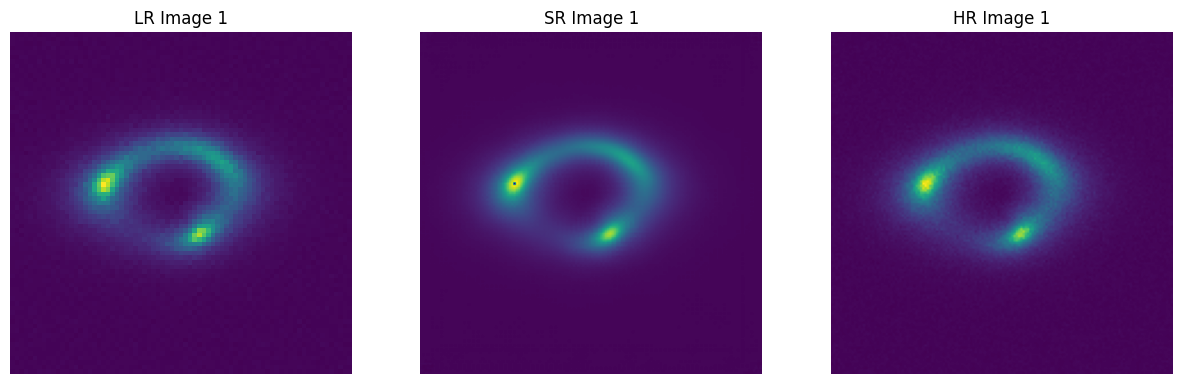

Image 2 - SSIM: 0.9702, PSNR: 39.96, MSE: 0.0001


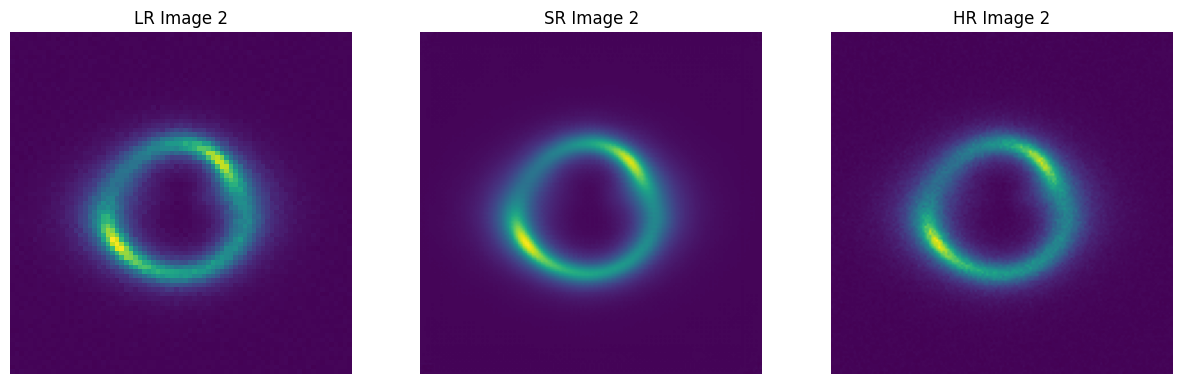

Image 3 - SSIM: 0.9700, PSNR: 41.01, MSE: 0.0001


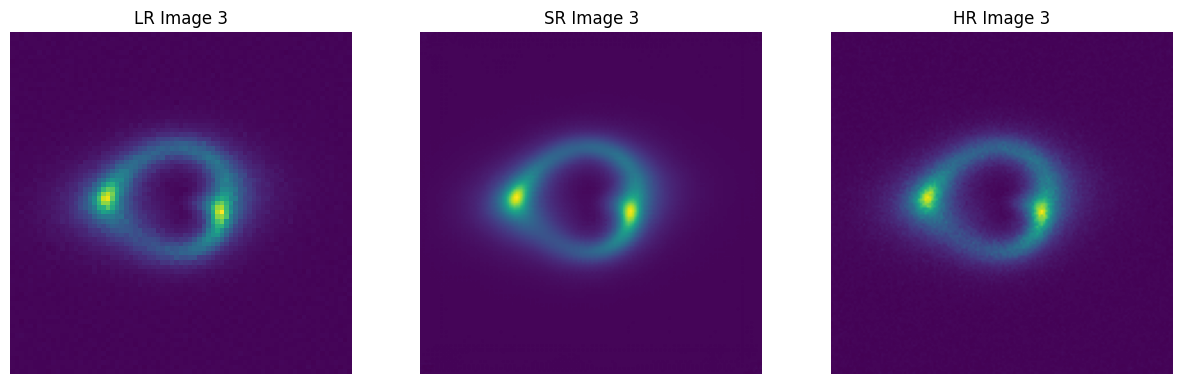

Image 4 - SSIM: 0.9665, PSNR: 40.27, MSE: 0.0001


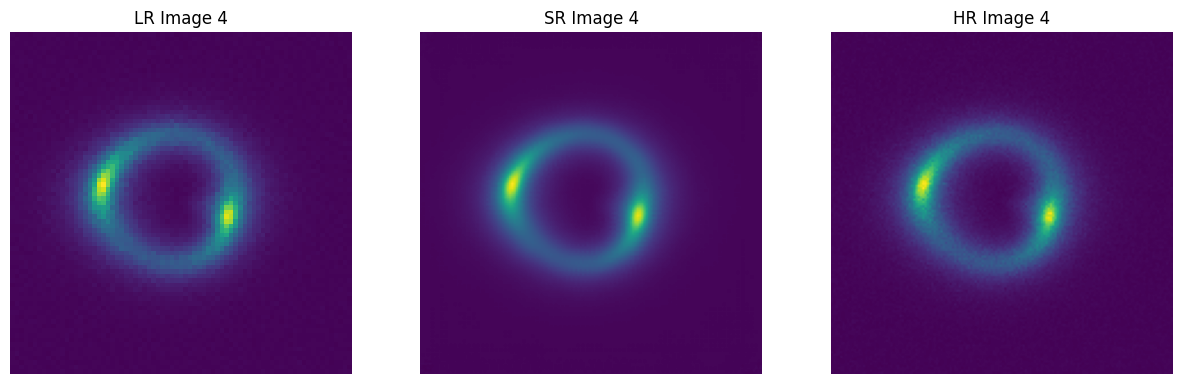

Image 5 - SSIM: 0.9677, PSNR: 40.87, MSE: 0.0001


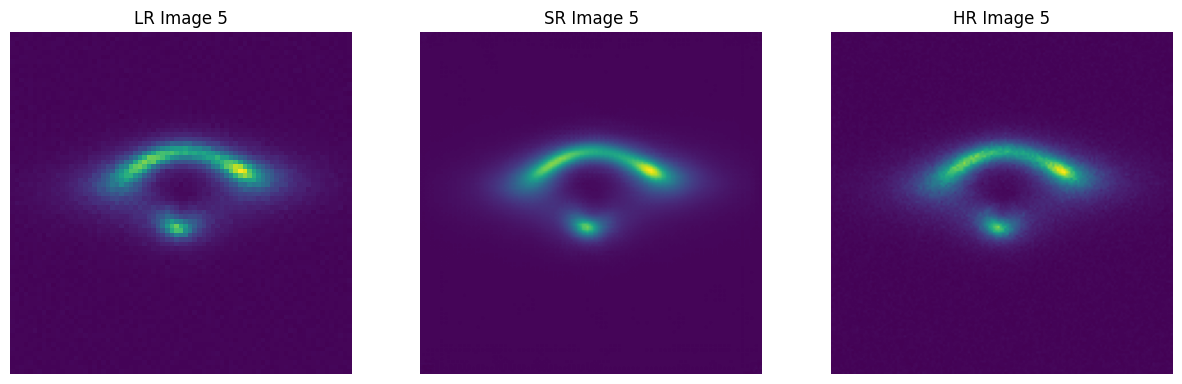

Image 6 - SSIM: 0.9642, PSNR: 40.63, MSE: 0.0001


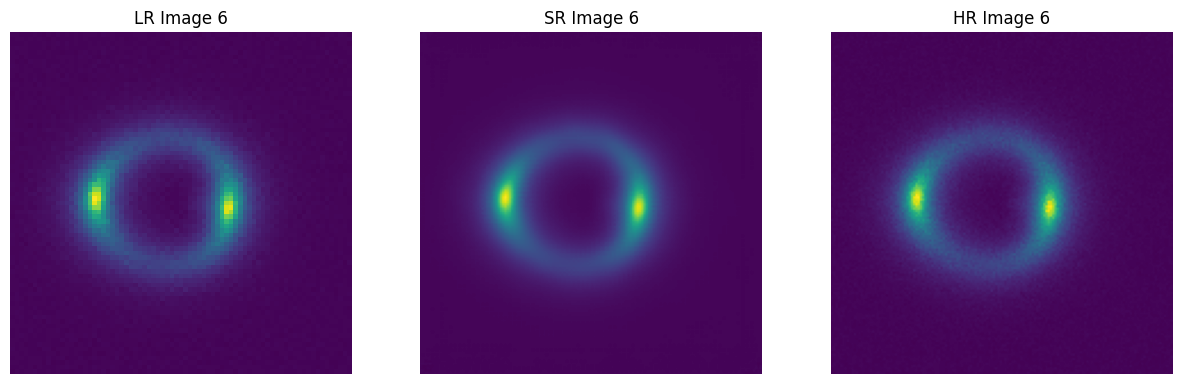

Image 7 - SSIM: 0.9712, PSNR: 41.02, MSE: 0.0001


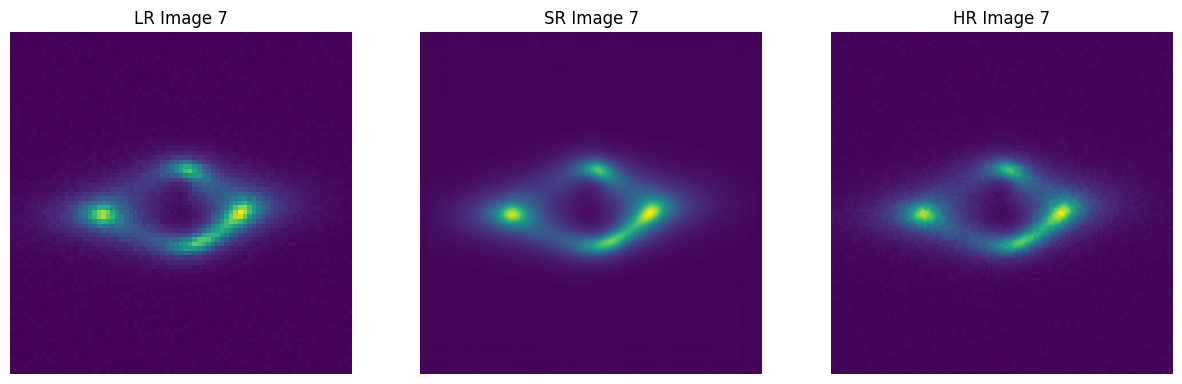

Image 8 - SSIM: 0.9685, PSNR: 41.11, MSE: 0.0001


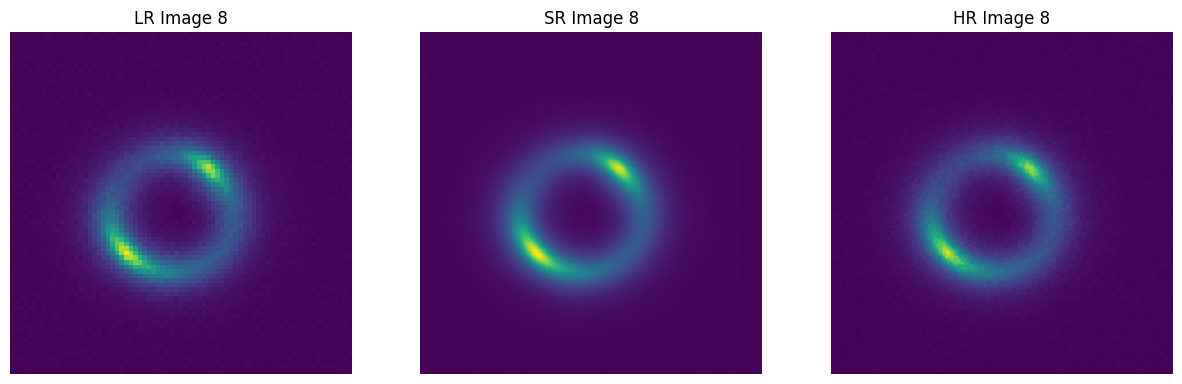

Image 9 - SSIM: 0.9703, PSNR: 41.49, MSE: 0.0001


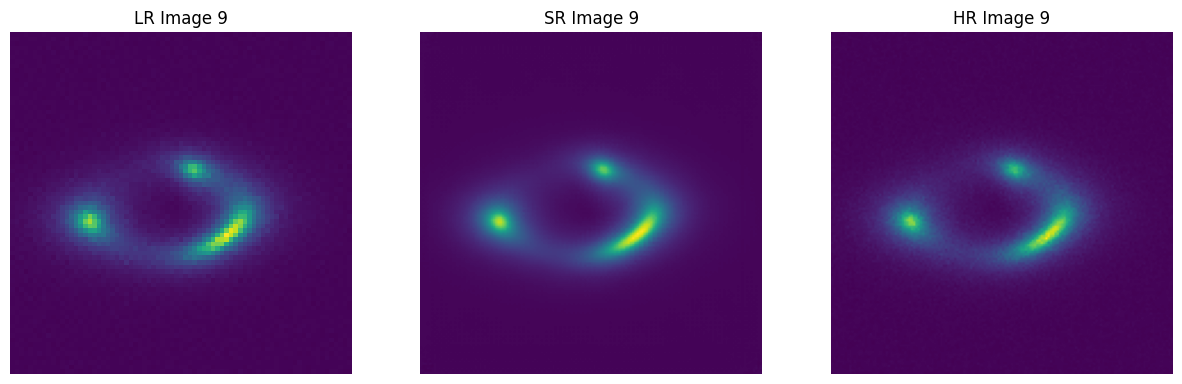

Image 10 - SSIM: 0.9633, PSNR: 41.40, MSE: 0.0001


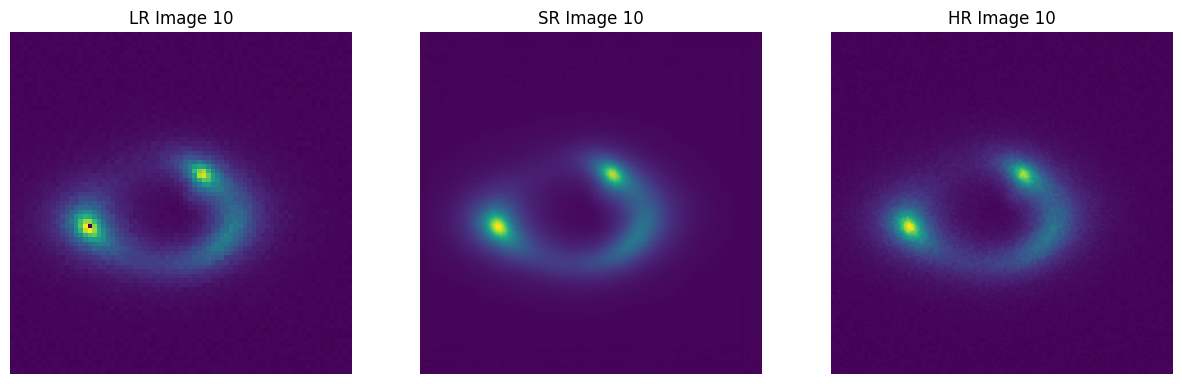

In [21]:
batch_demo = next(iter(val_loader))

lr_images, hr_images = batch_demo[0], batch_demo[1]

# Generate SR images using the loaded generator
with torch.no_grad():
    sr_images = gen(lr_images.float().to(DEVICE))

# Display LR vs SR vs HR triplets and calculate metrics
num_images = min(len(lr_images), 10)  # Display up to 10 images

for i in range(num_images):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(to_pil_image(lr_images[i].cpu()))
    plt.title(f'LR Image {i + 1}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(to_pil_image(sr_images[i].cpu()))
    plt.title(f'SR Image {i + 1}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(to_pil_image(hr_images[i].cpu()))
    plt.title(f'HR Image {i + 1}')
    plt.axis('off')

    # Calculate and print SSIM and PSNR
    ssim_value, psnr_value, mse_value = calculate_metrics(sr_images[i].cpu().squeeze().numpy(), hr_images[i].cpu().squeeze().numpy())
    print(f"Image {i + 1} - SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.2f}, MSE: {mse_value:.4f}")

    plt.show()


**Training the GAN**

In [19]:
train_losses = []
val_losses = []
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, EfficientNet_loss):
    train_loss = 0
    l2_losses = []
    adversarial_losses = []
    efficientnet_losses = []
    correct = 0
    total = 0

    for idx, (low_res, high_res) in enumerate(loader):
                
        high_res = high_res.to(DEVICE).float()
        low_res = low_res.to(DEVICE).float()   

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        disc_loss_real = bce(
            disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real)
        )
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        l2_loss = mse(fake, high_res)
        adversarial_loss =  bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_efficientNet =  EfficientNet_loss(fake, high_res)
        gen_loss =   10 * l2_loss  + .006 * loss_for_efficientNet + .001 * adversarial_loss

        
        train_loss += gen_loss.item()
        l2_losses.append(l2_loss.item())
        adversarial_losses.append(adversarial_loss.item())
        efficientnet_losses.append(loss_for_efficientNet.item())
        
        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()
        
    train_loss /= len(loader)
    train_losses.append(train_loss)
    
    l2_loss_mean = sum(l2_losses) / len(l2_losses)
    adversarial_loss_mean = sum(adversarial_losses) / len(adversarial_losses)
    efficientnet_loss_mean = sum(efficientnet_losses) / len(efficientnet_losses)
    
    print(f"Training, Train Loss: {train_loss:.8f}, L2 Loss: {l2_loss_mean:.8f}, Adversarial Loss: {adversarial_loss_mean:.8f}, EfficientNet Loss: {efficientnet_loss_mean:.8f}, Discriminator Loss: {loss_disc.item():.8f}")
        
    # Validation
    gen.eval()  # Set the generator to evaluation mode for validation
    with torch.no_grad():
        val_loss = 0.0
        l2_losses = []
        adversarial_losses = []
        efficientnet_losses = []
        for val_idx, (val_low_res, val_high_res) in enumerate(val_loader):
            val_low_res = val_low_res.to(DEVICE).float()
            val_high_res = val_high_res.to(DEVICE).float()
            val_fake = gen(val_low_res)
            l2_loss = mse(val_fake, val_high_res)
            adversarial_loss =  bce(disc(val_fake), torch.ones_like(disc(val_fake)))
            efficientnet_loss = EfficientNet_loss(val_fake, val_high_res)

            gen_loss = 10* l2_loss  + .006 * efficientnet_loss + .001 * adversarial_loss

            val_loss += gen_loss.item()
            
            l2_losses.append(l2_loss.item())
            adversarial_losses.append(adversarial_loss.item())
            efficientnet_losses.append(efficientnet_loss.item())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        l2_loss_mean = sum(l2_losses) / len(l2_losses)
        adversarial_loss_mean = sum(adversarial_losses) / len(adversarial_losses)
        efficientnet_loss_mean = sum(efficientnet_losses) / len(efficientnet_losses)
        
        print(f"Validation, Val Loss: {val_loss:.8f}, L2 Loss: {l2_loss_mean:.8f}, Adversarial Loss: {adversarial_loss_mean:.8f}, EfficientNet Loss: {efficientnet_loss_mean:.8f}")

    


In [25]:
NUM_EPOCHS = 25
LEARNING_RATE = .000001
gen_2 = Generator(in_channels=1).to(DEVICE)
#gen_2.load_state_dict(torch.load('/kaggle/input/esrgan/pytorch/srgan/10/gen_pretrain_l2_001_e3.pth'))

disc_2 = Discriminator(in_channels=1).to(DEVICE)
opt_gen = optim.Adam(gen_2.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc_2.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
EfficientNet_loss =EfficientNetLoss().to(DEVICE)



Loaded pretrained weights for efficientnet-b0


In [26]:
for epoch in range(NUM_EPOCHS):
    print(epoch)
    train_fn(train_loader, disc_2, gen_2, opt_gen, opt_disc, mse, bce, EfficientNet_loss)
    torch.save(gen_2.state_dict(), str(epoch)+'gen_1.pth')
    evaluate(val_loader, gen_2, output_folder = 'result/epoch'+str(epoch),img = True)
    


0
Training, Train Loss: 0.28578799, L2 Loss: 0.02826629, Adversarial Loss: 3.07059334, EfficientNet Loss: 0.00908923, Discriminator Loss: 0.15888119
Validation, Val Loss: 0.09028219, L2 Loss: 0.00855648, Adversarial Loss: 4.70018765, EfficientNet Loss: 0.00287123
Mean SSIM = 0.1527, Mean PSNR = 20.8112, Mean MSE = 0.0085

1
Training, Train Loss: 0.06151287, L2 Loss: 0.00562510, Adversarial Loss: 5.25058972, EfficientNet Loss: 0.00188603, Discriminator Loss: 0.19156767
Validation, Val Loss: 0.04599613, L2 Loss: 0.00403159, Adversarial Loss: 5.67210884, EfficientNet Loss: 0.00134840
Mean SSIM = 0.4842, Mean PSNR = 24.0679, Mean MSE = 0.0040

2
Training, Train Loss: 0.03675417, L2 Loss: 0.00309166, Adversarial Loss: 5.83138439, EfficientNet Loss: 0.00103139, Discriminator Loss: 0.21159130
Validation, Val Loss: 0.03009288, L2 Loss: 0.00241847, Adversarial Loss: 5.90334967, EfficientNet Loss: 0.00080507
Mean SSIM = 0.6068, Mean PSNR = 26.2751, Mean MSE = 0.0024

3
Training, Train Loss: 0.02

Image 1 - SSIM: 0.9354, PSNR: 37.56, MSE: 0.0002


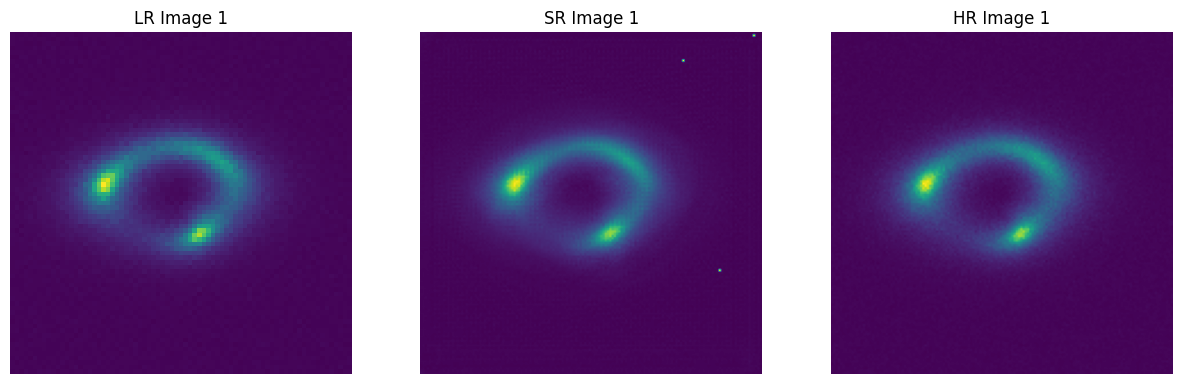

Image 2 - SSIM: 0.9395, PSNR: 36.37, MSE: 0.0002


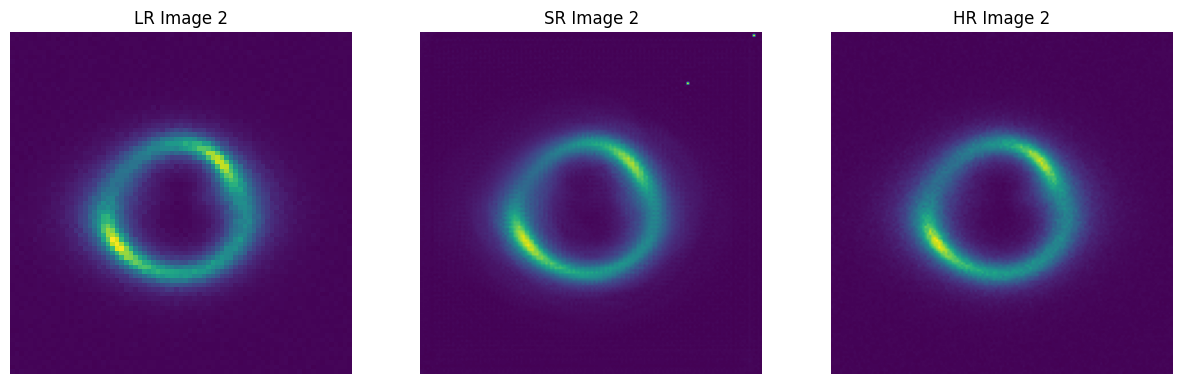

Image 3 - SSIM: 0.9392, PSNR: 37.65, MSE: 0.0002


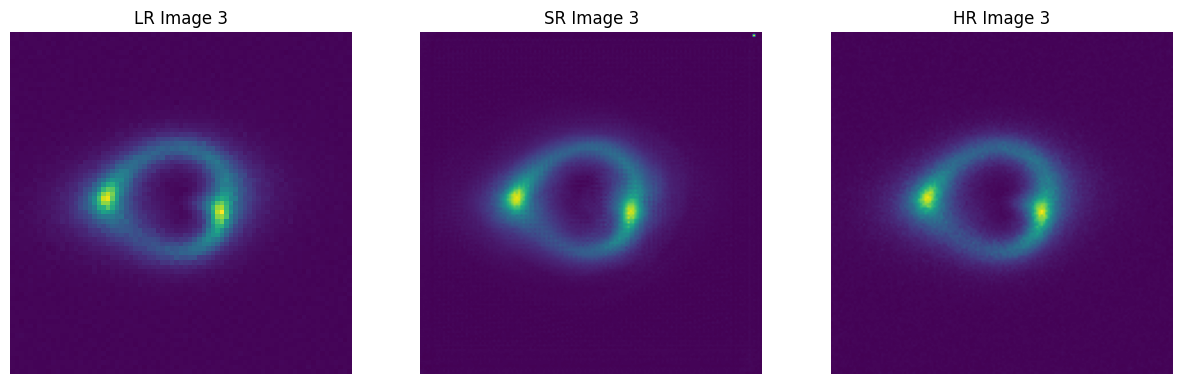

Image 4 - SSIM: 0.9371, PSNR: 37.46, MSE: 0.0002


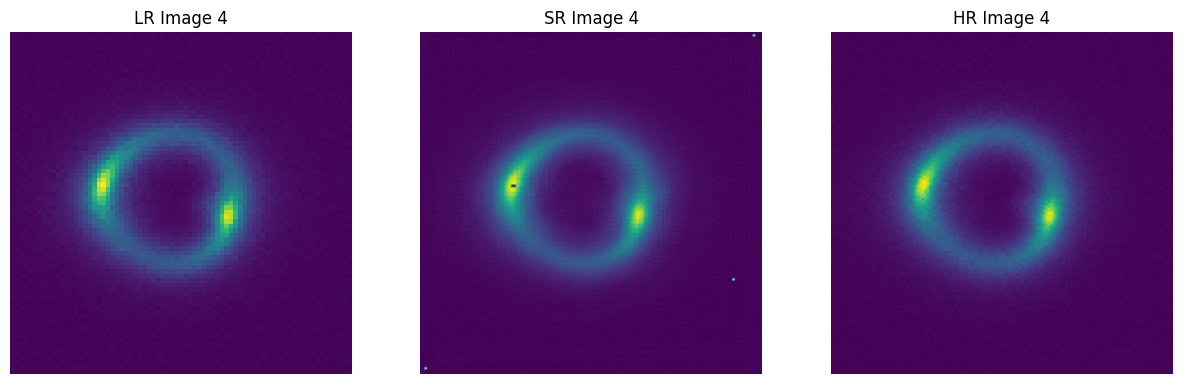

Image 5 - SSIM: 0.9333, PSNR: 37.33, MSE: 0.0002


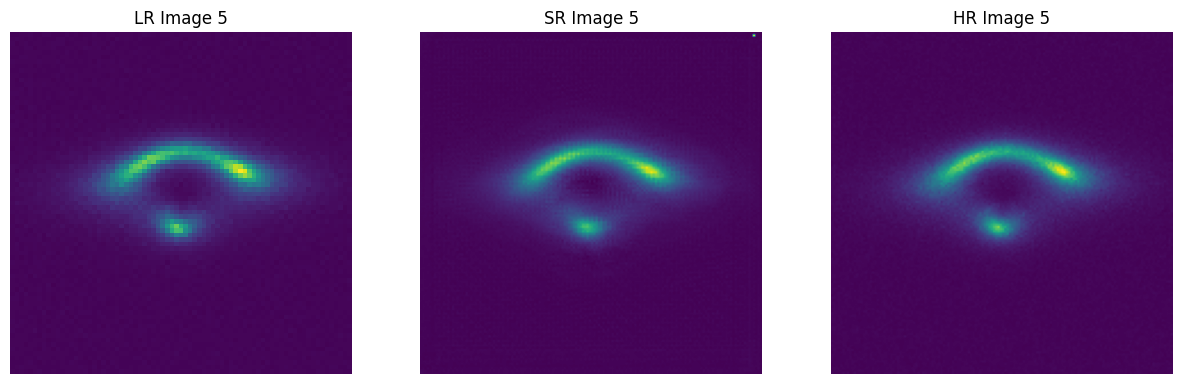

Image 6 - SSIM: 0.9328, PSNR: 37.63, MSE: 0.0002


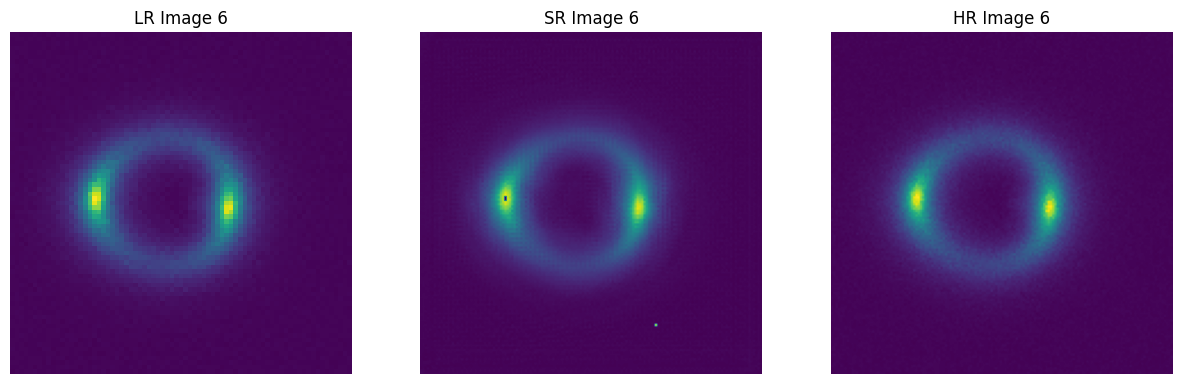

Image 7 - SSIM: 0.9401, PSNR: 37.53, MSE: 0.0002


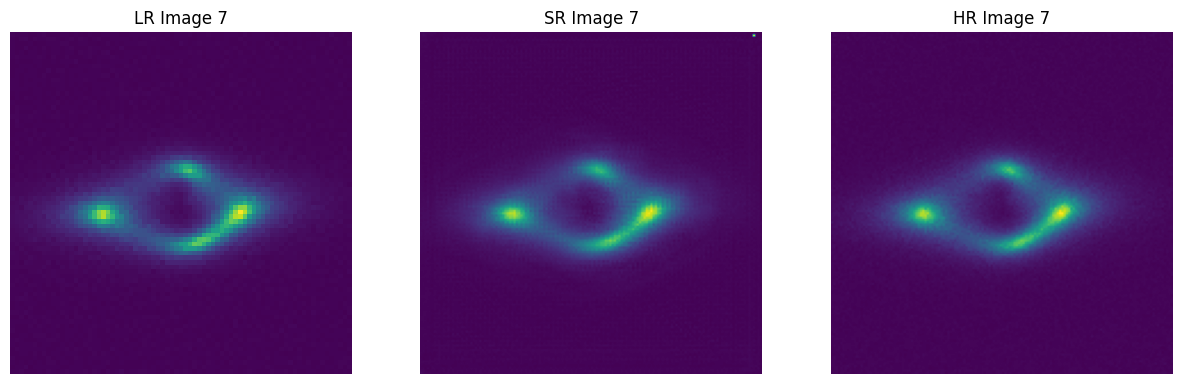

Image 8 - SSIM: 0.9401, PSNR: 37.88, MSE: 0.0002


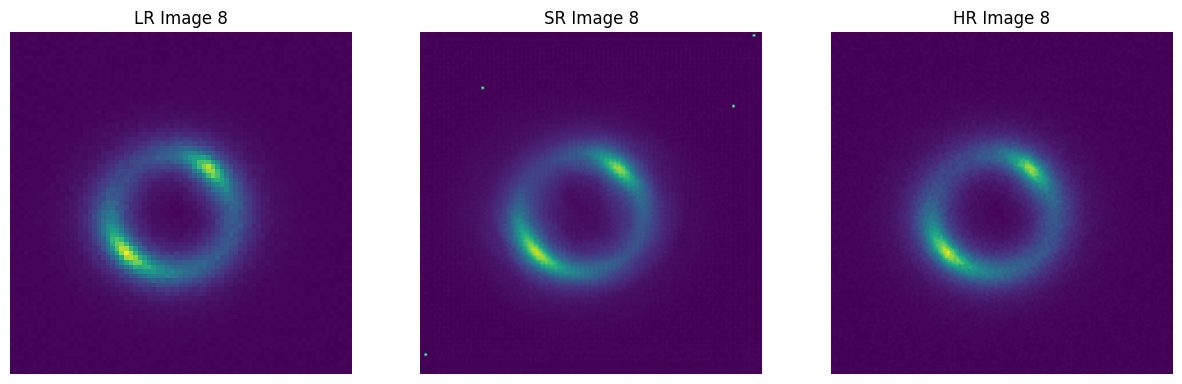

Image 9 - SSIM: 0.9426, PSNR: 38.28, MSE: 0.0001


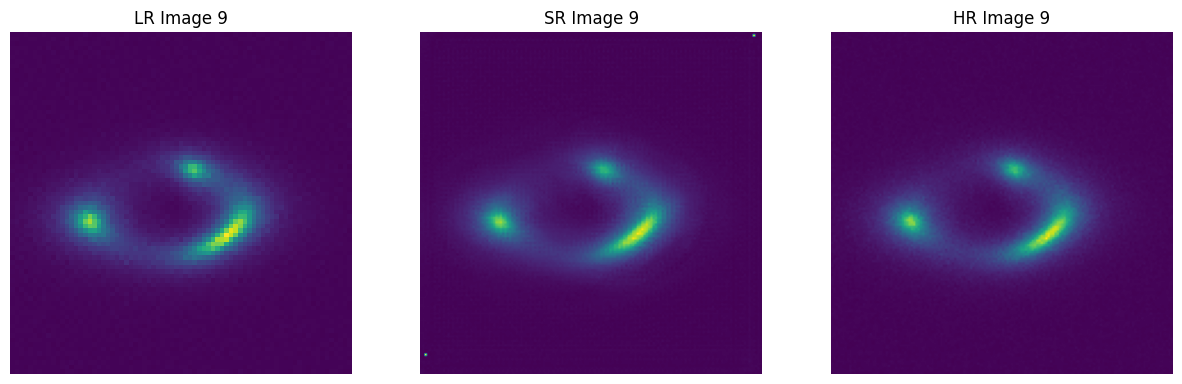

Image 10 - SSIM: 0.9312, PSNR: 38.18, MSE: 0.0002


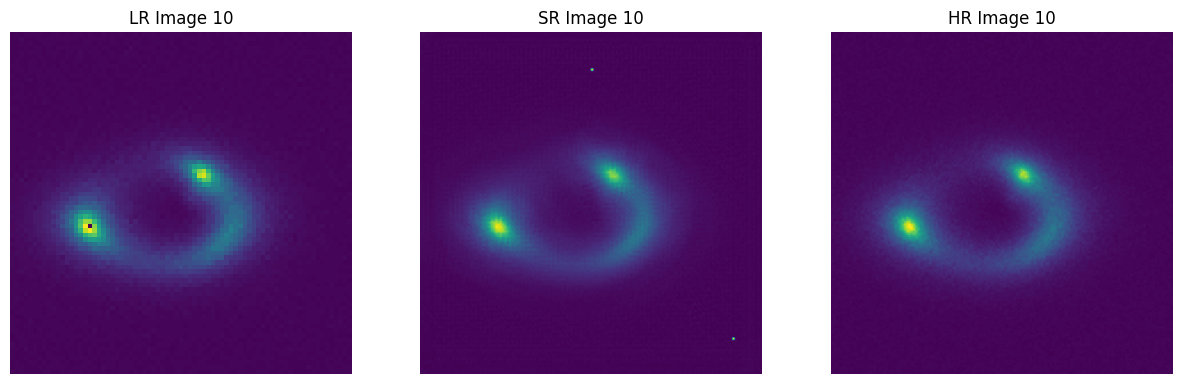

In [22]:
batch_demo = next(iter(val_loader))

lr_images, hr_images = batch_demo[0], batch_demo[1]

# Generate SR images using the loaded generator
with torch.no_grad():
    sr_images = gen_2(lr_images.float().to(DEVICE))

# Display LR vs SR vs HR triplets and calculate metrics
num_images = min(len(lr_images), 10)  # Display up to 10 images

for i in range(num_images):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(to_pil_image(lr_images[i].cpu()))
    plt.title(f'LR Image {i + 1}')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(to_pil_image(sr_images[i].cpu()))
    plt.title(f'SR Image {i + 1}')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(to_pil_image(hr_images[i].cpu()))
    plt.title(f'HR Image {i + 1}')
    plt.axis('off')

    # Calculate and print SSIM and PSNR
    ssim_value, psnr_value, mse_value = calculate_metrics(sr_images[i].cpu().squeeze().numpy(), hr_images[i].cpu().squeeze().numpy())
    print(f"Image {i + 1} - SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.2f}, MSE: {mse_value:.4f}")

    plt.show()
